## Structured Latent Spaces MNIST

In [1]:
import torch
import argparse
import MNIST_123 
device = "cuda" if torch.cuda.is_available() else "cpu"
args = argparse.Namespace(
    data_path="../data",
    batch_size=256,
    latent_dim=128,
    device=device
)

# Architecture Reasoning

---

## 1. Overview of Our Solution

We designed a contrastive autoencoder using a **lightweight convolutional encoder** trained on **augmented MNIST digit pairs**. The encoder was trained in a **self-supervised manner** using contrastive loss. After training, a small classifier was trained on frozen latent representations.

The core idea was to **learn digit representations** that are invariant to transformations. For this, we followed a SimCLR-inspired setup with strong data augmentation and a projection head that separates contrastive objectives from downstream tasks.

---

## 2. Encoder Architecture

### Structure Breakdown:
- **Conv1 (1 → 32 channels)**  
  - Kernel: 3×3, Stride: 2, Padding: 1  
  - Activation: ReLU  
  - Output size: 14×14

- **Conv2 (32 → 64 channels)**  
  - Kernel: 3×3, Stride: 2, Padding: 1  
  - Activation: ReLU  
  - Output size: 7×7

- **AdaptiveAvgPool2d → Linear → Latent**
  - Downsamples to 1×1 (global embedding)  
  - Fully connected layers: `64 → 256 → 128`  

### Why This Works:
- Compact yet expressive latent space
- Captures key shape and stroke information from digits
- Projection head improves generalization under contrastive loss

---

## 3. Contrastive Training

We use **NT-Xent contrastive loss**:
- Input: two different augmentations of the same image (positive pair)
- Negative pairs: other examples in the batch
- Metric: cosine similarity, scaled with temperature τ = 0.1

### Why Contrastive?
- Enables learning without labels
- Helps group similar digits in latent space
- Encourages representations to be robust to small perturbations

---

## 4. Classifier Design

We freeze the encoder and train a **simple classifier**:
- MLP: `128 → 64 → 10`
- Activation: ReLU
- Regularization: Dropout (0.2)

### Why This Works:
- Enough capacity for 10-digit classification
- Dropout prevents overfitting
- Uses frozen representations, allowing fair evaluation

---

## 5. Data Augmentation

### Applied to MNIST:
- Random resized crop
- Random rotation
- Random affine shift
- Normalization: `mean = 0.1307`, `std = 0.3081`

### Why It Helps:
- Prevents overfitting on small dataset
- Encourages model to learn shape semantics, not pixel locations

---

## 6. Training and Evaluation

| Component        | Choice                         | Reason                                      |
|------------------|--------------------------------|---------------------------------------------|
| Optimizer        | Adam                           | Fast and adaptive learning                  |
| Loss Function    | Contrastive + CrossEntropy     | Contrastive for self-supervised; CE for classification |
| Batch Size       | args.batch_size (user-defined) | Balanced for compute and performance        |
| Epochs           | 20 for AE, 15 for classifier   | Sufficient for convergence                  |
| LR Scheduler     | CosineAnnealingLR              | Helps fine-tune at the end of training      |

---

## 7. Evaluation Protocol

- Validation split: **90% train / 10% val**
- Classifier trained on frozen latent embeddings
- Validation accuracy tracked each epoch
- Best model saved based on validation
- Final accuracy reported on test set

---

## 8. Summary

This MNIST contrastive pipeline shows that even simple convolutional encoders can learn effective representations with the right self-supervised training and augmentations. Our encoder-classifier setup achieved strong test accuracy with a small model size and efficient training.



In [2]:
train_loader, val_loader, test_loader = MNIST_123.load_data(args)
autoencoder = MNIST_123.Autoencoder(latent_dim=args.latent_dim).to(args.device)

## Training Autoencoder

Epoch 1/30 | Train Loss: 3.2231 | Val Loss: 2.4694 | Test Loss: 1.9366


Epoch 2/30 | Train Loss: 2.2278 | Val Loss: 2.0180 | Test Loss: 1.6092


Epoch 3/30 | Train Loss: 1.9363 | Val Loss: 1.8175 | Test Loss: 1.4503


Epoch 4/30 | Train Loss: 1.8095 | Val Loss: 1.7063 | Test Loss: 1.3609


Epoch 5/30 | Train Loss: 1.7148 | Val Loss: 1.6671 | Test Loss: 1.3473


Epoch 6/30 | Train Loss: 1.6428 | Val Loss: 1.6131 | Test Loss: 1.3108


Epoch 7/30 | Train Loss: 1.5918 | Val Loss: 1.5634 | Test Loss: 1.2566


Epoch 8/30 | Train Loss: 1.5450 | Val Loss: 1.5135 | Test Loss: 1.1928


Epoch 9/30 | Train Loss: 1.5097 | Val Loss: 1.4971 | Test Loss: 1.1859


Epoch 10/30 | Train Loss: 1.4804 | Val Loss: 1.4465 | Test Loss: 1.1508


Epoch 11/30 | Train Loss: 1.4510 | Val Loss: 1.4185 | Test Loss: 1.1333


Epoch 12/30 | Train Loss: 1.4288 | Val Loss: 1.3999 | Test Loss: 1.1491


Epoch 13/30 | Train Loss: 1.4008 | Val Loss: 1.3896 | Test Loss: 1.0995


Epoch 14/30 | Train Loss: 1.3804 | Val Loss: 1.3832 | Test Loss: 1.1106


Epoch 15/30 | Train Loss: 1.3663 | Val Loss: 1.3278 | Test Loss: 1.0643


Epoch 16/30 | Train Loss: 1.3457 | Val Loss: 1.3429 | Test Loss: 1.0739


Epoch 17/30 | Train Loss: 1.3316 | Val Loss: 1.3275 | Test Loss: 1.0723


Epoch 18/30 | Train Loss: 1.3218 | Val Loss: 1.3205 | Test Loss: 1.0685


Epoch 19/30 | Train Loss: 1.3109 | Val Loss: 1.2988 | Test Loss: 1.0505


Epoch 20/30 | Train Loss: 1.3020 | Val Loss: 1.2872 | Test Loss: 1.0693


Epoch 21/30 | Train Loss: 1.2967 | Val Loss: 1.2760 | Test Loss: 1.0279


Epoch 22/30 | Train Loss: 1.2828 | Val Loss: 1.2782 | Test Loss: 1.0411


Epoch 23/30 | Train Loss: 1.2786 | Val Loss: 1.2696 | Test Loss: 1.0196


Epoch 24/30 | Train Loss: 1.2708 | Val Loss: 1.2596 | Test Loss: 1.0276


Epoch 25/30 | Train Loss: 1.2645 | Val Loss: 1.2550 | Test Loss: 1.0245


Epoch 26/30 | Train Loss: 1.2574 | Val Loss: 1.2538 | Test Loss: 1.0159


Epoch 27/30 | Train Loss: 1.2597 | Val Loss: 1.2612 | Test Loss: 1.0131


Epoch 28/30 | Train Loss: 1.2576 | Val Loss: 1.2577 | Test Loss: 1.0113


Epoch 29/30 | Train Loss: 1.2530 | Val Loss: 1.2365 | Test Loss: 1.0128


Epoch 30/30 | Train Loss: 1.2504 | Val Loss: 1.2501 | Test Loss: 1.0121


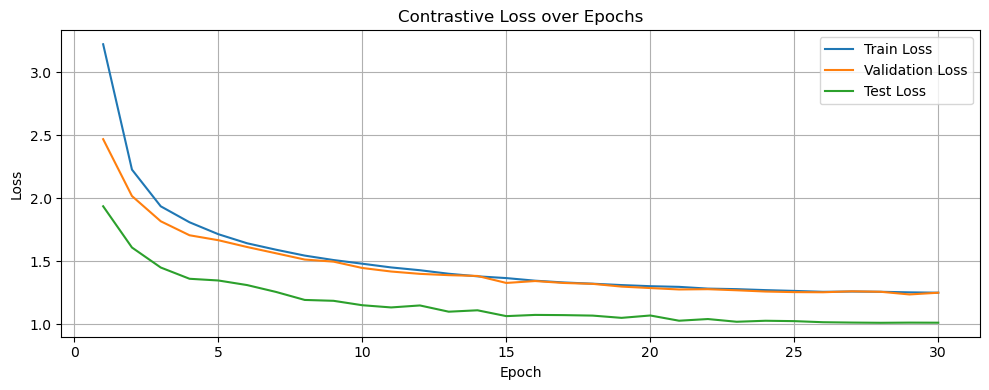

In [3]:
MNIST_123.train_autoencoder(autoencoder, train_loader, val_loader, test_loader,args,epochs=30)

## Training Classifier

Epoch 1/30 | Train Loss: 2.2395, Acc: 29.85% | Val Acc: 72.35% | Test Acc: 74.51%


Epoch 2/30 | Train Loss: 1.8665, Acc: 68.09% | Val Acc: 77.45% | Test Acc: 81.52%


Epoch 3/30 | Train Loss: 1.3911, Acc: 73.52% | Val Acc: 79.97% | Test Acc: 84.01%


Epoch 4/30 | Train Loss: 1.0718, Acc: 76.96% | Val Acc: 82.00% | Test Acc: 85.05%


Epoch 5/30 | Train Loss: 0.8804, Acc: 79.07% | Val Acc: 82.60% | Test Acc: 85.96%


Epoch 6/30 | Train Loss: 0.7644, Acc: 80.75% | Val Acc: 83.00% | Test Acc: 86.64%


Epoch 7/30 | Train Loss: 0.6923, Acc: 81.61% | Val Acc: 84.02% | Test Acc: 87.32%


Epoch 8/30 | Train Loss: 0.6363, Acc: 82.46% | Val Acc: 84.28% | Test Acc: 87.85%


Epoch 9/30 | Train Loss: 0.5955, Acc: 83.31% | Val Acc: 84.72% | Test Acc: 88.25%


Epoch 10/30 | Train Loss: 0.5670, Acc: 83.64% | Val Acc: 84.52% | Test Acc: 88.54%


Epoch 11/30 | Train Loss: 0.5391, Acc: 84.14% | Val Acc: 85.67% | Test Acc: 88.91%


Epoch 12/30 | Train Loss: 0.5200, Acc: 84.54% | Val Acc: 85.92% | Test Acc: 88.99%


Epoch 13/30 | Train Loss: 0.5009, Acc: 85.03% | Val Acc: 86.37% | Test Acc: 89.29%


Epoch 14/30 | Train Loss: 0.4903, Acc: 85.17% | Val Acc: 85.82% | Test Acc: 89.49%


Epoch 15/30 | Train Loss: 0.4770, Acc: 85.42% | Val Acc: 86.10% | Test Acc: 89.64%


Epoch 16/30 | Train Loss: 0.4691, Acc: 85.58% | Val Acc: 86.85% | Test Acc: 89.72%


Epoch 17/30 | Train Loss: 0.4621, Acc: 85.78% | Val Acc: 86.70% | Test Acc: 89.85%


Epoch 18/30 | Train Loss: 0.4515, Acc: 85.86% | Val Acc: 86.53% | Test Acc: 89.94%


Epoch 19/30 | Train Loss: 0.4478, Acc: 86.03% | Val Acc: 86.88% | Test Acc: 89.99%


Epoch 20/30 | Train Loss: 0.4418, Acc: 86.15% | Val Acc: 86.57% | Test Acc: 90.09%


Epoch 21/30 | Train Loss: 0.4369, Acc: 86.27% | Val Acc: 86.67% | Test Acc: 90.04%


Epoch 22/30 | Train Loss: 0.4347, Acc: 86.19% | Val Acc: 87.08% | Test Acc: 90.12%


Epoch 23/30 | Train Loss: 0.4317, Acc: 86.36% | Val Acc: 86.55% | Test Acc: 90.24%


Epoch 24/30 | Train Loss: 0.4223, Acc: 86.69% | Val Acc: 87.08% | Test Acc: 90.37%


Epoch 25/30 | Train Loss: 0.4190, Acc: 86.69% | Val Acc: 87.58% | Test Acc: 90.38%


Epoch 26/30 | Train Loss: 0.4181, Acc: 86.79% | Val Acc: 87.65% | Test Acc: 90.42%


Epoch 27/30 | Train Loss: 0.4108, Acc: 86.96% | Val Acc: 87.38% | Test Acc: 90.49%


Epoch 28/30 | Train Loss: 0.4087, Acc: 87.03% | Val Acc: 87.38% | Test Acc: 90.51%


Epoch 29/30 | Train Loss: 0.4021, Acc: 87.21% | Val Acc: 87.85% | Test Acc: 90.53%


Epoch 30/30 | Train Loss: 0.4011, Acc: 87.21% | Val Acc: 87.87% | Test Acc: 90.64%


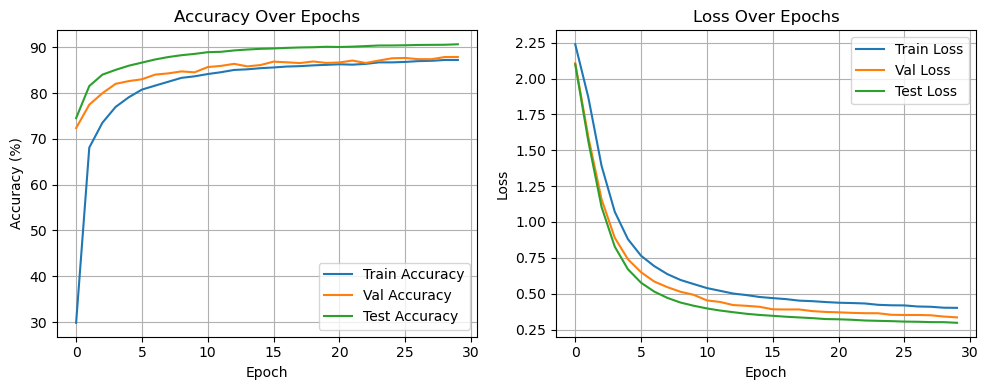

In [4]:
MNIST_123.train_classifier(autoencoder, train_loader, val_loader, test_loader, args,epochs=30)

## t-SNE Analysis of Latent Spaces

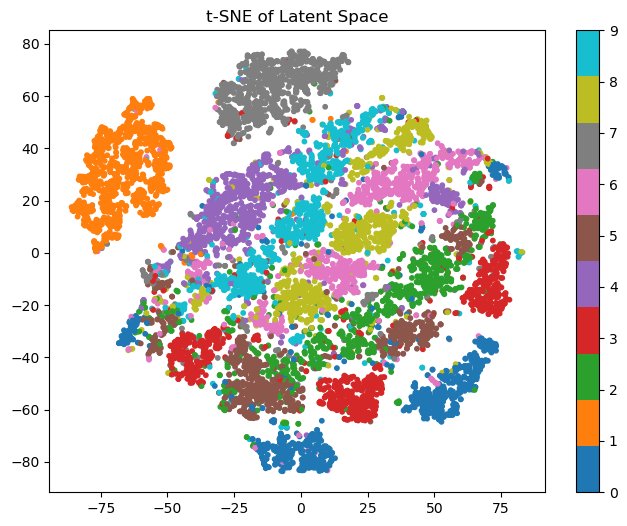

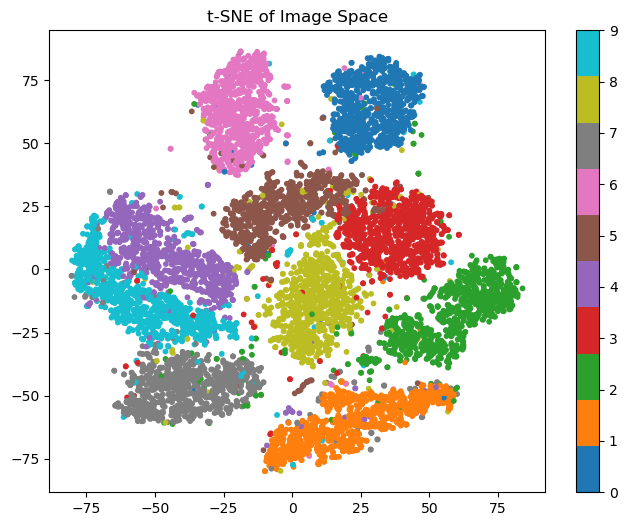

In [5]:
MNIST_123.plot_tsne(autoencoder, test_loader, args.device)